In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import matplotlib.ticker as ticker
from scipy.integrate import simps

from sklearn.linear_model import LinearRegression

In [111]:
BASE_PATH = '../tp5/out/flux/'

In [33]:
def get_linear_regresssion(df):
    x = np.array(df.index)
    y = np.array(df['sum'])
    A = np.vstack([x, np.ones(len(x))]).T
    m, c = np.linalg.lstsq(A, y, rcond=None)[0]
    return m , c

In [34]:
def get_simulation_data(df):
    time_flux = df.groupby('time').agg({'ball_id':'count'}); 
    return {
        'discharge' : pd.DataFrame({'time': time_flux.index,'sum': time_flux.cumsum()['ball_id']})
    }

In [121]:
def plot_flux(figure,tiempo, discharge, line):
    plt.plot(tiempo, discharge,marker='x', label='Descarga')
    plt.plot(tiempo, line, label='Regresión lineal')
    plt.xlabel('Tiempo')
    plt.ylabel('Cantidad de pelotas')
    plt.grid(True)
    plt.legend()
    plt.savefig(figure)
    plt.clf()

In [85]:
def plot_map(name,plot_map, xlabel, ylabel, log_scale):
    x = [position for position in plot_map.keys()]
    y = [value[0] for value in plot_map.values()]
    errors = [value[1] for value in plot_map.values()]
        
    plt.errorbar(x, y, yerr=errors, fmt='o', color='black', ecolor='red', capsize=3)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    if log_scale:
        plt.yscale("log")
    plt.xticks(x)
    plt.grid(True)
    plt.savefig(name)
    plt.clf()

In [128]:
def get_charge(path):
    df = pd.read_csv(path)
    df = get_simulation_data(df)
    df = df['discharge']
    m, c = get_linear_regresssion(df)
    y = m * (df.index) + c
    S = np.sqrt(sum((df['sum'] - y) ** 2) / (len(df.time) - 2))
    time_mean = np.mean(df.index)
    SS = np.sqrt(sum((df.index - time_mean) ** 2))
    return m, (S/SS)
    

In [129]:
# generate the caudal vs frequency graph  
def plot_caudal_by_frequency():
    path = f"{BASE_PATH}/"
    frequencies = [5,10, 15, 20, 30, 50]
    result = {}
    for freq in frequencies: 
        regex = '*fq'+ str(freq)+'*_i*.csv'
        files = Path(path).glob(regex)
        dfs = [get_charge(f) for f in files][0]
        result[freq] = dfs
    plot_map("fluxVsFreq.png", result, "Frecuencia", "Caudal", False)

plot_caudal_by_frequency()


<Figure size 640x480 with 0 Axes>

In [122]:
# generate all the discharge curves  
def plot_discharge_line():
    base = f"{BASE_PATH}/"
    frequencies = [5,10, 15, 20, 30, 50]
    for freq in frequencies: 
        regex = '*fq'+ str(freq)+'*_i*.csv'
        files = Path(base).glob(regex)
        path = [f for f in files][0]
        plot_discharge_line_for_freq(freq, path)
plot_discharge_line()
        

<Figure size 640x480 with 0 Axes>

In [125]:
    # function for generating the discharge curve for the freq, 
    # receiving the csv path as parameter
    def plot_discharge_line_for_freq(freq, path):        
        df = pd.read_csv(path)
        df = get_simulation_data(df)
        df = df['discharge']
        m, c = get_linear_regresssion(df)
        y = m * (df.index) + c
        plot_flux(f'{freq}Discharge.png',df.index, df['sum'], y)

time         4.000000
particles    7.333333
dtype: float64

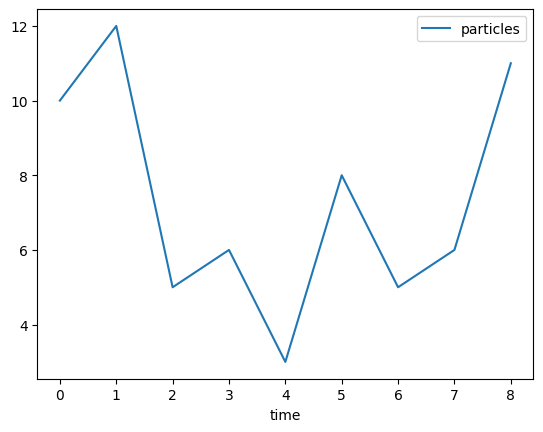

In [161]:
time_delta = 1
time_bins = np.arange(0, 10, time_delta)

data = []
df_without_index = df.reset_index()
for i in range(0, len(time_bins) - 1):
    lower = time_bins[i]
    upper = time_bins[i + 1]

    particles = df_without_index[(df_without_index['time'] < upper) & (df_without_index['time'] >= lower)]['ball_id'].sum()
    data.append({'time': lower, 'particles': particles})

q_df = pd.DataFrame(data)
q_df.plot(x='time', y='particles')

q_df.mean()

<Axes: xlabel='Timestamp'>

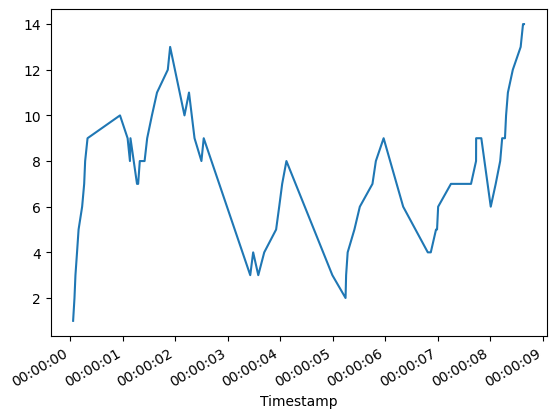

In [164]:
rolling_df = df.copy().reset_index()
rolling_df['Timestamp'] = pd.to_datetime(rolling_df['time'], unit='s')
rolling_df.set_index('Timestamp', inplace=True)
rolling_df.rolling(window='1000ms')['ball_id'].sum().plot()